# Milestone Project :- Research Paper analysis

Here we build an NLP model to read medical Research paper easily.



In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# Get the data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.zip


In [ ]:
# Start our experiments
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
# Check the filenames
import os
filenames = (data_dir + filenames for filenames in os.listdir(data_dir))
filenames

<generator object <genexpr> at 0x7a4cd9ccb370>

## Preprocess data

In [ ]:
# Create a function to read the lines of document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of test as a list.

  filename : a string containing the target filepath
  """
  with open(filename,"r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines

# Let's read in the training lines
train_lines = get_lines(data_dir + "/train.txt")

In [ ]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

In [ ]:

# Write a function to turn our dataset into a specific format
def preprocess_text_with_line_numbers(filename):
  """
  return a list of dictionaries
  """
  input_lines = get_lines(filename)
  abstract_lines = ""  # Create an empty abstract
  abstract_samples = [] # Create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line  # this line and the following lines should be indented
      abstract_lines = "" # this line and the following lines should be indented
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() # this line and the following lines should be indented
      for abstract_line_number , abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples



In [ ]:



# Get data from file and preprocess it
%%time
train_samples=preprocess_text_with_line_numbers(data_dir + "/train.txt") # Added '/' to fix path issue
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt") # Added '/' to fix path issue
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt") # Fixed typo and added '/'
print(len(train_samples), len(val_samples) , len(test_samples))

180040 30212 30135
CPU times: user 524 ms, sys: 163 ms, total: 687 ms
Wall time: 760 ms


In [ ]:
# Check the first abstract of training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries,

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:


# Distribution of labels in training data
train_df['target'].value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


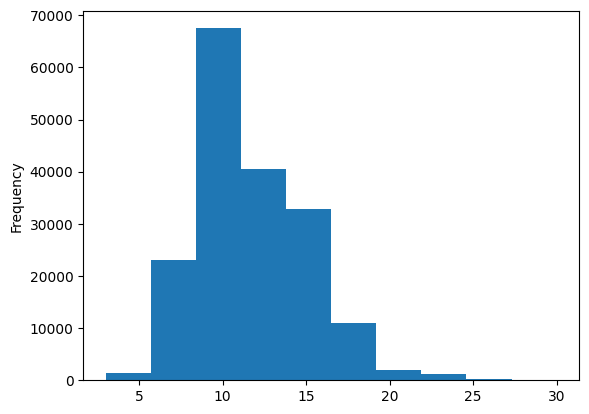

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

## Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences) , len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels(ML models require numeric labels)

In [ ]:

# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode the

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [ ]:
import sklearn
print(sklearn.__version__)

1.6.1


In [ ]:
# Export labels ("target columns") and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Checking , how the training labels look like
train_labels_encoded



array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Strating to do model experiments

### Model 0 : Getting a Baseline

In [ ]:
!pip install scikit-learn

In [ ]:


!pip install scikit-learn


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization pipeline
model_0 = Pipeline([
                    ("tfidf",TfidfVectorizer()),
                    ("clf",MultinomialNB())
])

# Fit the pipeline
model_0.fit(train_sentences,
            train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evalute the baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-04-16 03:30:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-04-16 03:30:50 (62.9 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preparing our data (the text ) for deep sequence models

Before we start building deeper models , we've got to create vectorization and embedding layers

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [ ]:
# How long is each sentence on average ?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len


np.float64(26.338269273494777)

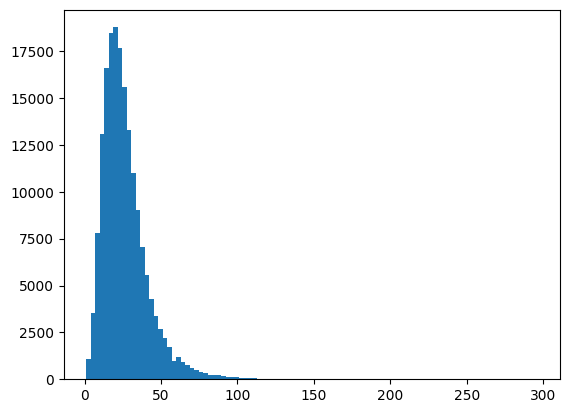

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens , bins=100 );

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens , 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)

296

## Create text vectorizer layer
we want to make a layer which maps our texts from words to number

In [ ]:
# no. of words are in our vocab ?
max_tokens = 68000

In [ ]:
# # Create a text vectorizer
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# text_vectorizer = TextVectorization(max_tokens = max_tokens,
#                                     output_sequence_length = output_seq_len)


# Create a text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [ ]:
# Adapt Text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nlength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:{text_vectorizer([target_sentence])}")

Text:
university of sevilla , spain .

length of text: 6

Vectorized text:[[  735     4 45747  4515     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# No. of words in our training vocublary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of')]
Least common words in the vocab: [np.str_('aainduced'), np.str_('aaigroup'), np.str_('aachener'), np.str_('aachen'), np.str_('aaacp')]


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim= 128,
                               mask_zero=True,
                               name="token_embedding"
                               )

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embeded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embeded_sentence}\n")
print(f"Embeded sentence shape: {embeded_sentence.shape}")

Sentence before vectorization:
university of sevilla , spain .

Sentence after vectorization (before embedding):
[[  735     4 45747  4515     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.03741697  0.04424641  0.00835695 ... -0.00188226 -0.02331946
   -0.0285136 ]
  [ 0.03442654 -0.03893337  0.04631891 ...  0.01418778  0.02302791
   -0.04389289]
  [ 0.02598077  0.0441314   0.03033446 ... -0.02281511  0.0454311
   -0.01023431]
  ...
  [-0.04806794 -0.03639008 -0.03909982 ... -0.01052145  0.03369992
    0.004679  ]
  [-0.04806794 -0.03639008 -0.03909982 ... -0.01052145  0.03369992
    0.004679  ]
  [-0.04806794 -0.03639008 -0.03909982 ... -0.01052145  0.03369992
    0.004679  ]]]

Embeded sent

## Creating datasets

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))








train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels_one_hot.shape , train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1 : Conv1D with token embeddings

In [ ]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
# Creating 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)  # Vectorize the text inputs
token_embeddings = token_embed(text_vectors)  # Create embedding
x = layers.Conv1D(64 , kernel_size=5,padding = "same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # Condense the output of our feature vector
outputs = layers.Dense(num_classes , activation = "softmax")(x)
model1 = tf.keras.Model(inputs,outputs)

# Compile
model1.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Fit the model
history_model_1 = model1.fit(train_dataset,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             epochs=3,
                             validation_data=val_dataset, # Changed from valid_dataset to val_dataset
                             validation_steps=int(0.1 * len(val_dataset)))  # only validate on 10% of batches

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 60s 100ms/step - accuracy: 0.5185 - loss: 1.1669 - val_accuracy: 0.7360 - val_loss: 0.6872
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.7466 - loss: 0.6869 - val_accuracy: 0.7729 - val_loss: 0.6408
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.7663 - loss: 0.6257 - val_accuracy: 0.7879 - val_loss: 0.6014


In [ ]:
# Evaluate on whole validation dataset
model1.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7876 - loss: 0.5991


[0.6006746292114258, 0.7872699499130249]

In [ ]:
# Make predictions
model1_pred_probs = model1.predict(val_dataset)
model1_pred_probs, model1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


(array([[4.6197796e-01, 1.4442526e-01, 5.5590209e-02, 3.0795041e-01,
         3.0056154e-02],
        [4.5779192e-01, 2.8056806e-01, 9.9335797e-03, 2.4348211e-01,
         8.2242694e-03],
        [1.8154587e-01, 6.1495486e-03, 2.7164421e-03, 8.0955571e-01,
         3.2416225e-05],
        ...,
        [1.0289518e-05, 7.3641987e-04, 7.0269807e-04, 6.1484484e-06,
         9.9854445e-01],
        [5.5616606e-02, 4.1842270e-01, 8.0744177e-02, 5.7890300e-02,
         3.8732621e-01],
        [1.6890366e-01, 6.7118806e-01, 4.8839163e-02, 5.8397666e-02,
         5.2671365e-02]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert the pred probs to classes
model1_preds = tf.argmax(model1_pred_probs , axis=1)
model1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
# Model1 result

model1_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model1_preds)
model1_results

{'accuracy': 78.7269958956706,
 'precision': 0.7838789428895986,
 'recall': 0.7872699589567059,
 'f1': 0.7852062115952143}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Model 4: Combining pretrained token embeddings + character embeddings (hybrid model)

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers

# Wrap the TensorFlow Hub layer in a custom Keras layer
class HubLayer(layers.Layer):
    def __init__(self, handle, trainable=False, **kwargs):
        super(HubLayer, self).__init__(trainable=trainable, **kwargs)
        self.handle = handle

    def build(self, input_shape):
        self.hub_layer = hub.KerasLayer(self.handle, trainable=self.trainable)
        super(HubLayer, self).build(input_shape)

    def call(self, inputs):
        return self.hub_layer(inputs)

# Assume tf_hub_embedding_layer_handle contains the handle for your USE layer
tf_hub_embedding_layer_handle = 'https://tfhub.dev/google/universal-sentence-encoder/4'

# Create an instance of the custom layer
tf_hub_embedding_layer = HubLayer(tf_hub_embedding_layer_handle)

# Set up the token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)  # Use the custom layer here
token_output = layers.Dense(128, activation="relu")(token_embeddings)

token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

In [ ]:
# Set up the token inputs/model

token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)

token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

In [ ]:
# Setup char inputs/model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

# Assuming you want to create a character-level vectorizer:
max_chars = 100  # Maximum number of characters to keep
char_vectorizer = TextVectorization(max_tokens=max_chars, # Set a reasonable value
                                    output_sequence_length=output_seq_len,
                                    name="char_vectorizer")

# Adapt the character vectorizer to your character data (e.g., train_chars):
# Replace train_chars with the actual list of your character data
train_chars = ["".join(sentence.split()) for sentence in train_sentences]
char_vectorizer.adapt(train_chars)


# Assuming you also need a char embedding layer:
char_embed = layers.Embedding(input_dim=max_chars, # Should match char_vectorizer max_tokens
                               output_dim=128,
                               mask_zero=True,
                               name="char_embedding")

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)   # from the paper

char_model = tf.keras.Model(
    inputs= char_inputs,
    outputs= char_bi_lstm
)

In [ ]:
# Concatenate token and char outputs

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

In [ ]:
# Create the output layers - adding in Dropout, as in the paper

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [ ]:
# Finally create the model

model_4 = tf.keras.Model(
    inputs= [token_model.inputs, char_model.inputs],
    outputs= output_layer,
    name="model_4_hybrid"
)

In [ ]:
# get the summary

model_4.summary()

Model: "model_4_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 55)        │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hub_layer_1         │ (None, 512)       │          0 │ token_input[0][0] │
│ (HubLayer)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embedding      │ (None, 55, 128)   │     12,800 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 55)        │          0 │ char_vectorizer[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     65,664 │ hub_layer_1[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 48)        │     29,376 │ char_embedding[0… │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid   │ (None, 176)       │          0 │ dense_11[0][0],   │
│ (Concatenate)       │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 176)       │          0 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     22,656 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 5)         │        645 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 131,141 (512.27 KB)

 Trainable params: 131,141 (512.27 KB)

 Non-trainable params: 0 (0.00 B)

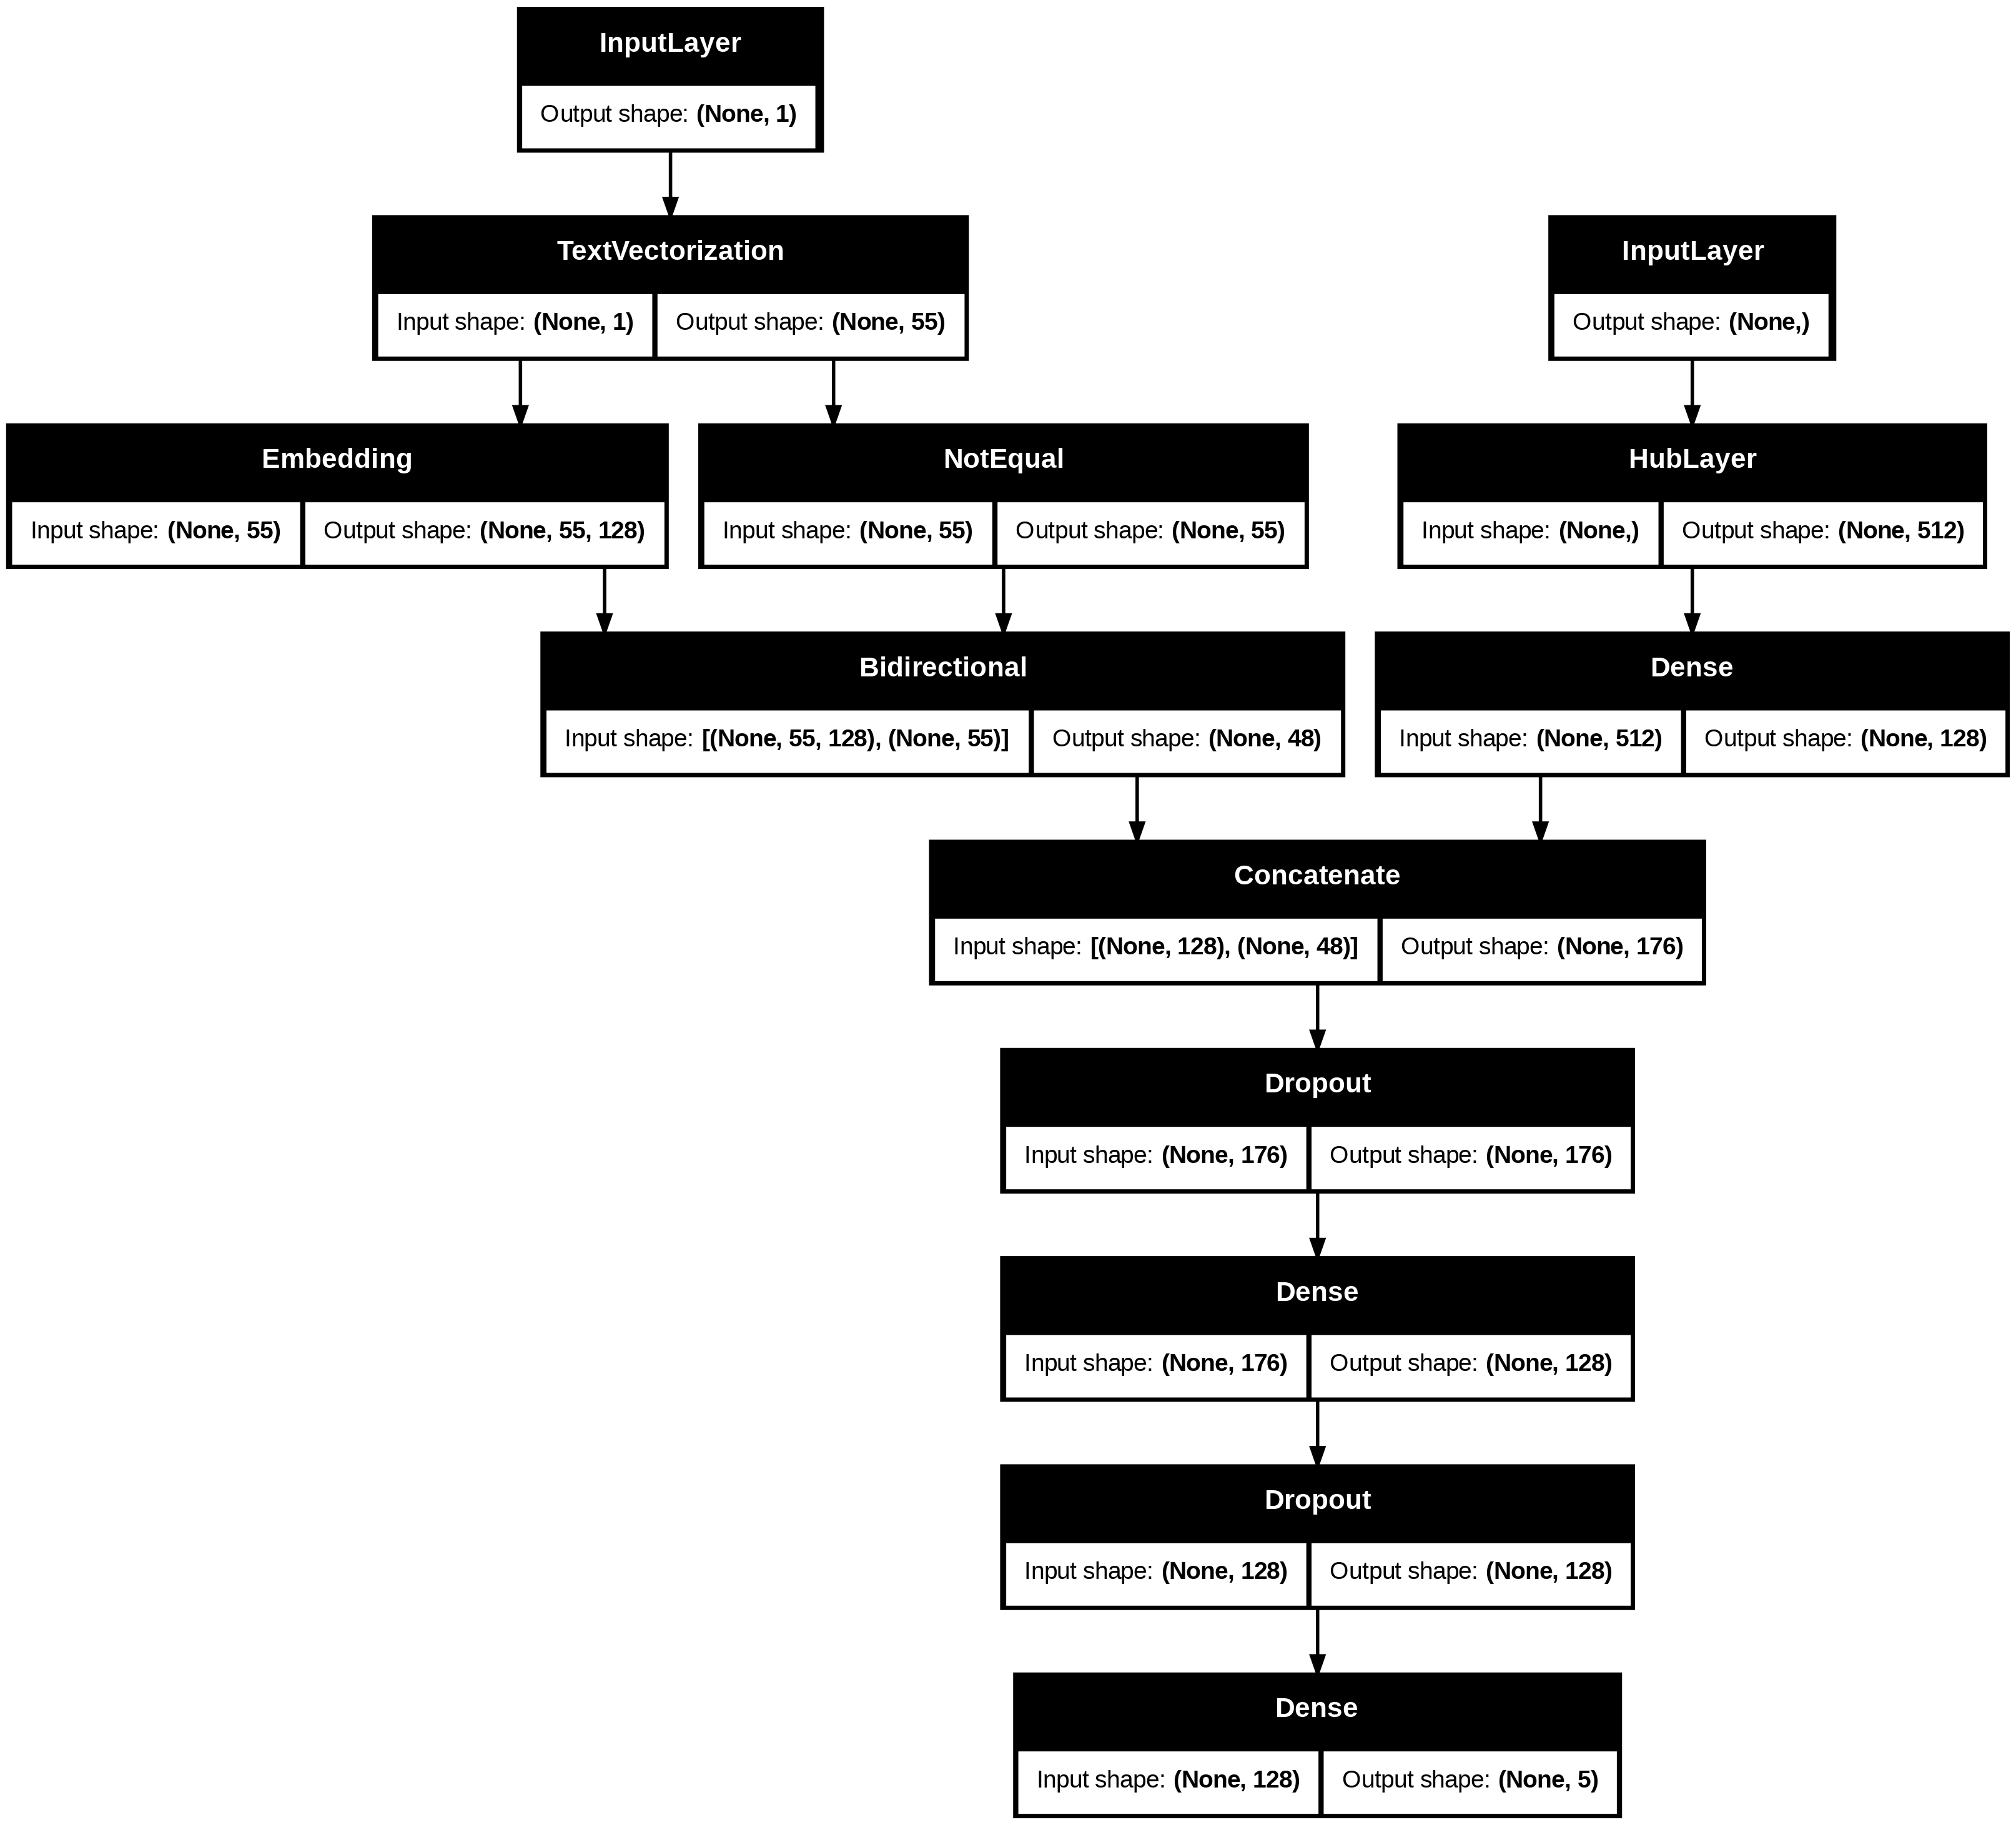

In [ ]:
# Plot the hybrid model to help visualize such model

from tensorflow.keras.utils import plot_model

plot_model(model_4, show_shapes=True)

In [ ]:
# Compile the model

model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),    # the paper states SGD, however, Ill try it with Adam
    metrics=["accuracy"]
)

In [ ]:
# Combine chars and tokens into a dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

In [ ]:
# Create prefetch and apply batch size

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Perform the same creation for both val and test data

# Create val_chars similar to how train_chars was created
val_chars = ["".join(sentence.split()) for sentence in val_sentences]

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Create test_chars similar to how train_chars was created
test_chars = ["".join(sentence.split()) for sentence in test_sentences]

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset, test_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model

history_model_4 = model_4.fit(
    train_char_token_dataset,
    epochs=3,
    steps_per_epoch= int(0.1 * len(train_char_token_dataset)), # Cast to integer
    validation_data= val_char_token_dataset,
    validation_steps= int(0.1 * len(val_char_token_dataset)) # Cast to integer
)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['token_input'], ['char_input']]
Received: inputs=('Tensor(shape=(None,))', 'Tensor(shape=(None,))')
  warnings.warn(msg)


562/562 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.5233 - loss: 1.1710 - val_accuracy: 0.6855 - val_loss: 0.8241
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.6763 - loss: 0.8338 - val_accuracy: 0.7121 - val_loss: 0.7521
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 83s 147ms/step - accuracy: 0.6923 - loss: 0.7996 - val_accuracy: 0.7301 - val_loss: 0.7197


In [ ]:
# Evaluate on the val dataset

model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.7259 - loss: 0.7200


[0.7209305763244629, 0.7251423001289368]

In [ ]:
# Make predictions using the hybrid model

model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['token_input'], ['char_input']]
Received: inputs=('Tensor(shape=(32,))', 'Tensor(shape=(32,))')
  warnings.warn(msg)


945/945 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step


array([[4.0777430e-01, 3.5726127e-01, 5.1723765e-03, 2.2196539e-01,
        7.8266114e-03],
       [2.9182121e-01, 5.8168489e-01, 2.6986969e-03, 1.2201319e-01,
        1.7819759e-03],
       [2.3683186e-01, 1.2126387e-01, 4.7272455e-02, 5.6224978e-01,
        3.2382082e-02],
       ...,
       [5.8735267e-04, 9.7570196e-03, 5.9637178e-02, 3.3955343e-04,
        9.2967892e-01],
       [4.8045875e-03, 5.2152846e-02, 2.8606975e-01, 2.5049550e-03,
        6.5446788e-01],
       [3.3877906e-01, 2.5783786e-01, 3.1676647e-01, 3.4254350e-02,
        5.2362181e-02]], dtype=float32)

In [ ]:
# Convert the predicition probabilities to prediction labels

model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [ ]:
# Calculate the results of the model

model_4_result = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_4_preds
)

model_4_result

{'accuracy': 72.5142327551966,
 'precision': 0.7267911209493265,
 'recall': 0.7251423275519661,
 'f1': 0.7221793152805875}

### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

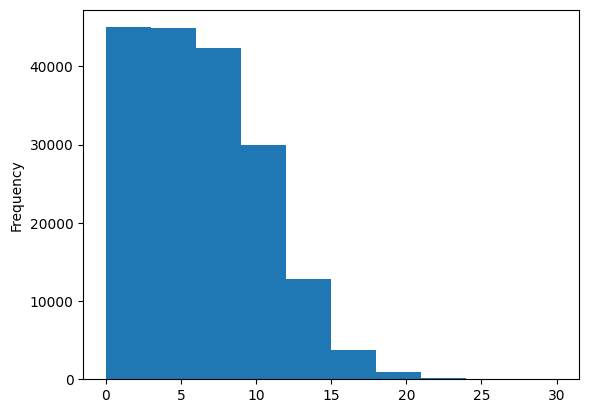

In [ ]:
# Check the distribution of line number column

train_df.line_number.plot.hist()

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
# Perform the same encoding to val and test data

val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth=15)

In [ ]:
# Perform the same steps to the feature total lines

# Get the total lines count

train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

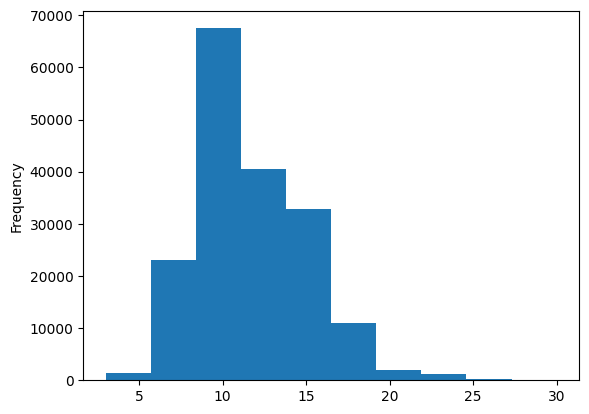

In [ ]:
# See what the distribution look like for total lines

train_df["total_lines"].plot.hist()

In [ ]:
# Encode the total lines feature

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [ ]:
# Perform the same encoding to val and test data

val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
# Get a summary of this huge model

model_5.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_inputs         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_inputs        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 55)        │          0 │ char_inputs[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hub_layer_1         │ (None, 512)       │          0 │ token_inputs[0][… │
│ (HubLayer)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embedding      │ (None, 55, 128)   │     12,800 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 55)        │          0 │ char_vectorizer[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     65,664 │ hub_layer_1[2][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 64)        │     41,216 │ char_embedding[1… │
│ (Bidirectional)     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid_… │ (None, 192)       │          0 │ dense_14[0][0],   │
│ (Concatenate)       │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_input   │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_input   │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 256)       │     49,408 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │        672 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_positio… │ (None, 320)       │          0 │ dense_15[0][0],   │
│ (Concatenate)       │                   │            │ dense_16[0][0],   │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      1,605 │ token_char_posit… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 171,877 (671.39 KB)

 Trainable params: 171,877 (671.39 KB)

 Non-trainable params: 0 (0.00 B)

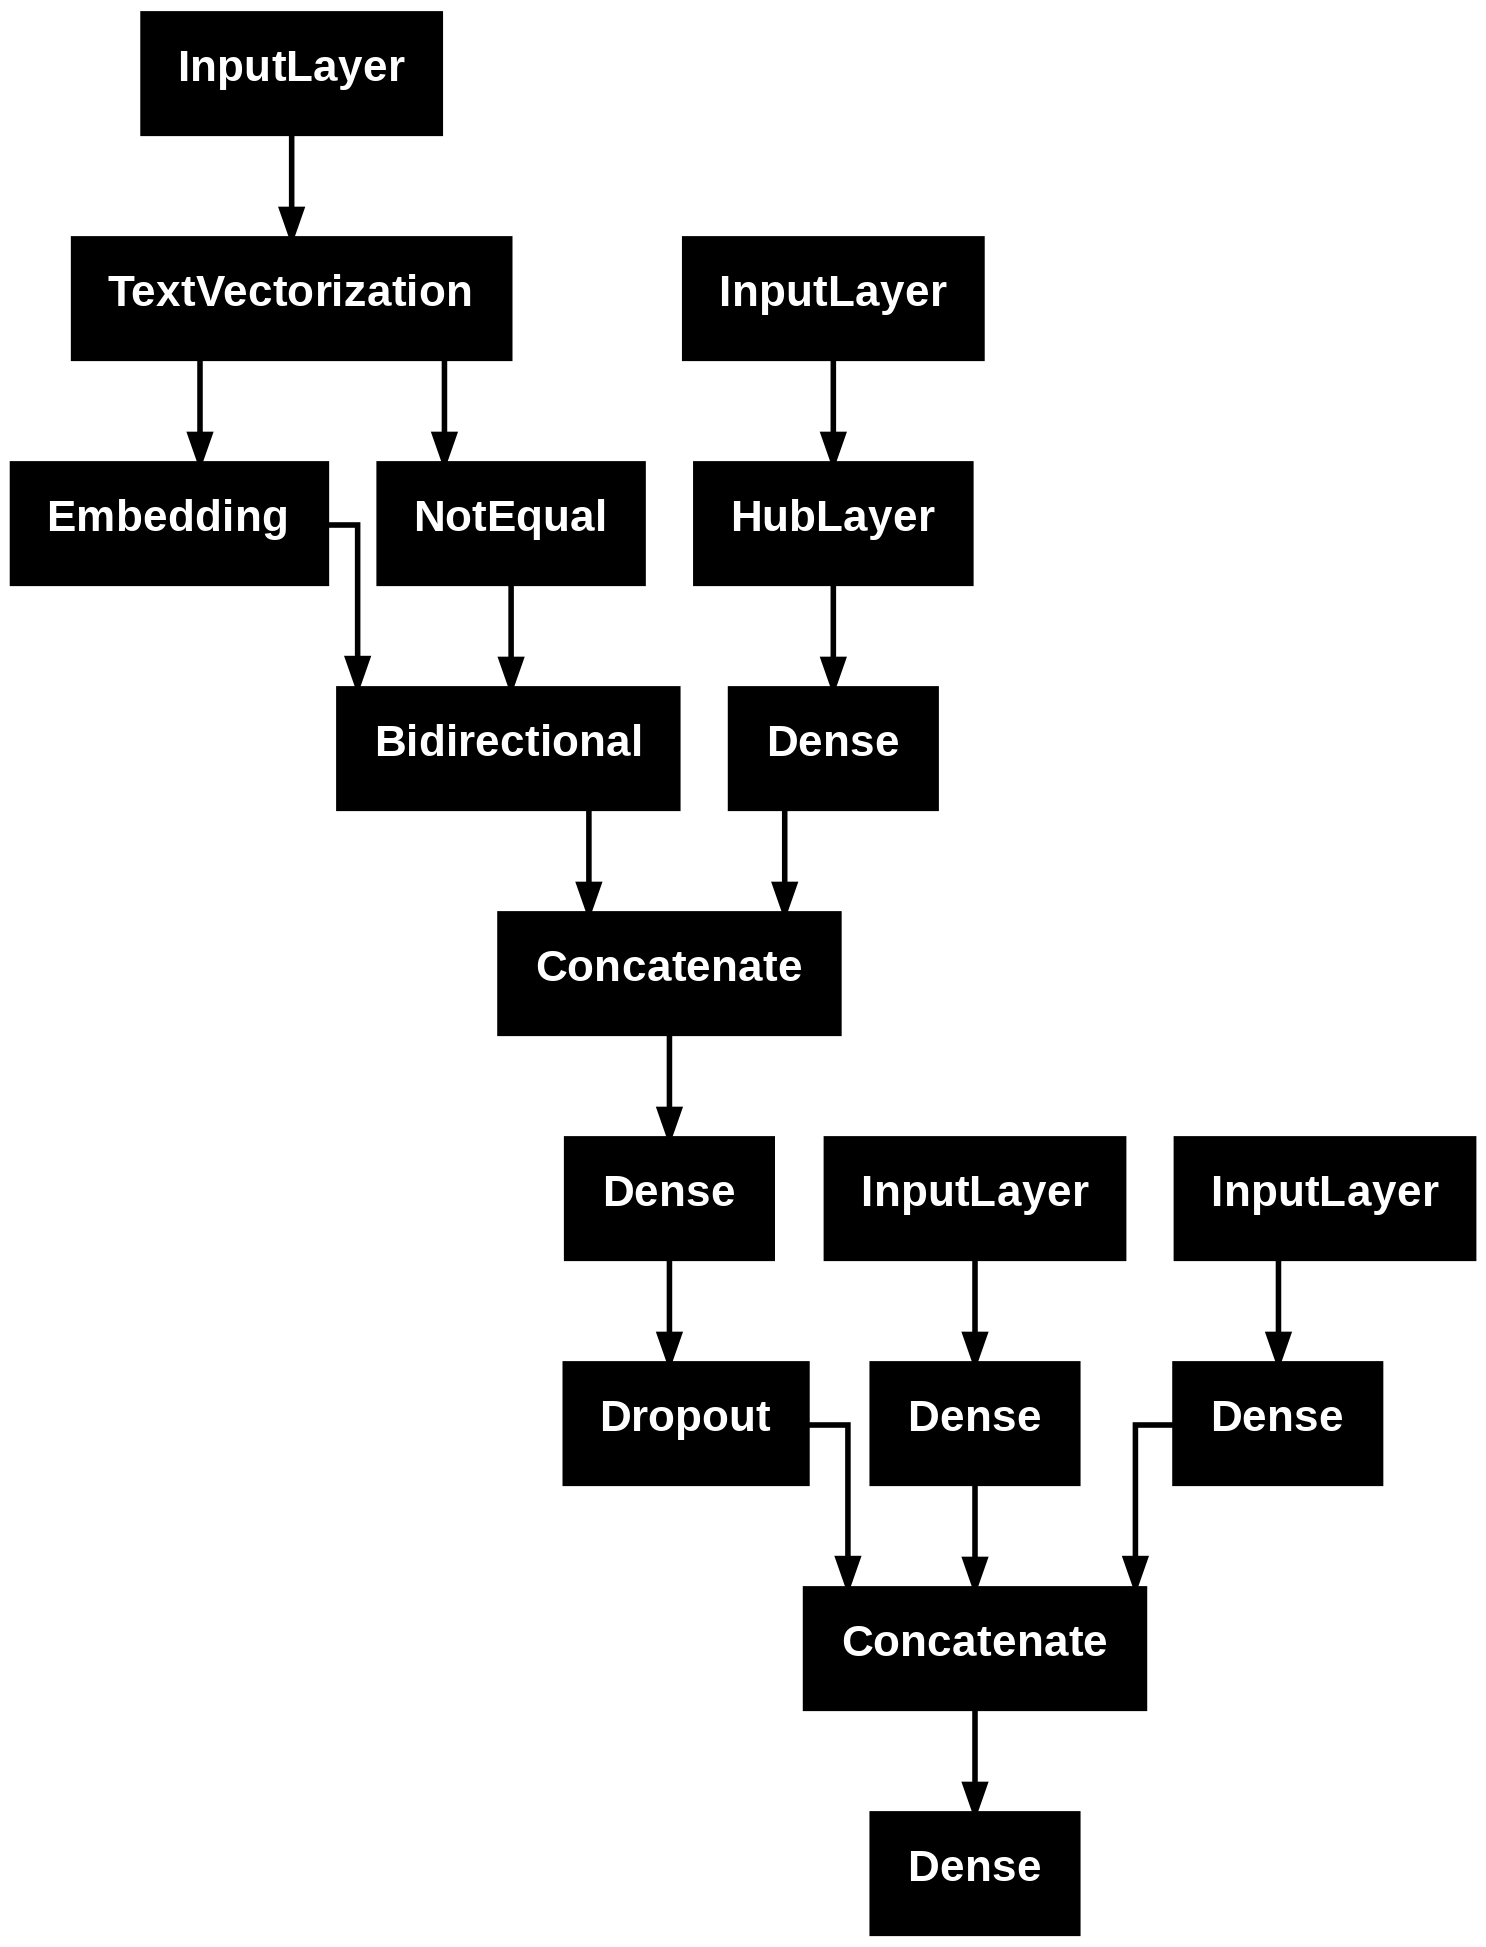

In [ ]:
# Plot the model architecture to understand its complexities

tf.keras.utils.plot_model(model_5, )

In [ ]:
model_5.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),     # helps avoid overfitting (label_smoothing)
    optimizer= tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:

train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Output the results

train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Finally, fit the model

history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 57s 88ms/step - accuracy: 0.6196 - loss: 1.2374 - val_accuracy: 0.8009 - val_loss: 0.9880
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.8033 - loss: 0.9771 - val_accuracy: 0.8208 - val_loss: 0.9577
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 147ms/step - accuracy: 0.8168 - loss: 0.9591 - val_accuracy: 0.8291 - val_loss: 0.9439


In [ ]:
# Make predictions
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step


array([[0.48623756, 0.10129894, 0.01064398, 0.38361856, 0.01820098],
       [0.56298935, 0.11992563, 0.03296484, 0.27673566, 0.00738458],
       [0.25372562, 0.12494324, 0.1484496 , 0.40386906, 0.06901257],
       ...,
       [0.03146531, 0.11377415, 0.04413735, 0.03358106, 0.77704215],
       [0.02597176, 0.29327282, 0.06418893, 0.02316046, 0.593406  ],
       [0.40775946, 0.36241627, 0.14442661, 0.04462971, 0.04076793]],
      dtype=float32)

In [ ]:
# Convert the probabilities to labels

model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 0])>

In [ ]:
# Calculate the results of model 5

model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 82.98027273930887,
 'precision': 0.8281340727530295,
 'recall': 0.8298027273930888,
 'f1': 0.8287089383881943}